# MANUAL DE LABORATORIO DE COMUNICACIONES DIGITALES: PYTHON
F. Javier Payán Somet, Juan José Murillo-Fuentes, José Carlos Aradillas Jaramillo \
_Departamento de Teoría de la Señal y Comunicaciones_ \
_Escuela Técnica Superior de Ingeniería_ \
_Universidad de Sevilla_ 

# Tema 5. Modulador Lineal II, PSK y QAM

**Este notebook contiene código del Tema 5**

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/gapsc-us/labcomdig/blob/main/Tema5.Transmisor_Lineal_II_(PSK_y_QAM).ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Inicialización

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Numpy ≥1.16 is required
import numpy as np
assert np.__version__ >= "1.16"

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore") #Ignorar warnings

## Modulación M-PSK

### Diseño experimental de un transmisor M-PSK

**Código 5.1** Transmisor M-PSK.

Las funciones que se describen aquí están en el fichero labcomdig.py

In [2]:
def transmisorpsk(Bn,Eb,M,p1,p2,L): 
   '''
   [Xn,Bn,An,phi1,phi2,alfabeto] = transmisorpsk(Bn,Eb,M,p1,p2,L)
   
   Entradas:
      Bn = Secuencia de dígitos binarios
      Eb = Energía media por bit transmitida en Julios
      M = Número de símbolos del código PSK
      p1 = Pulso real de la componente en fase
      p2 = Pulso real de la componente en cuadratura
      L = Número de puntos que se utilizará en la representación de un símbolo
   
   Devuelve:
      Xn = la señal de información discreta
      Bn = La secuencia de dígitos binarios realmente transmitidos
      An = La secuencia de símbolos complejos transmitidos
      phi1 = Pulso básico real normalizado (energí­a unidad) de la componente en fase
      phi2 = Pulso básico real normalizado (energí­a unidad) de la componente en cuadratura
      alfabeto = El alfabeto utilizado asociado a cada símbolo transmitido
   '''
   
   #Comprobación de parámetros de entrada
   p1 = p1.squeeze()
   p2 = p2.squeeze()
   if len(Bn)<1 or Eb<=0 or M<2 or p1@p1==0 or p2@p2==0 or L<1:
      raise Exception('Error: revise los parámetros de entrada')
        
   #Definiciones
   eps = np.finfo(float).eps # por debajo de este valor se considera cero
    
   # Comprobación de pulsos
   Ls1 = len(p1)
   Ls2 = len(p2) 
   if Ls1<L:
      p1 = np.r_[p1, np.zeros(int(L-Ls1))]
   elif Ls1>L:
      p1 = p1[:L]
      print('La duración del pulso se trunca a {} muestras'.format(str(L)))
   if Ls2<L:
      p2 = np.r_[p2, np.zeros(int(L-Ls2))]
   elif Ls2>L:
      p2 = p2[:L]
      print('La duración del pulso se trunca a {} muestras'.format(str(L)))       
       
   # Se comprueba la ortogonalidad
   if abs(p1@p2) >= 1e2*eps:
      raise Exception('No es posible realizar la transmisión')  
       
   # Se normalizan las energías de los pulsos
   phi1 = p1 / np.sqrt(p1@p1) 
   phi2 = p2 / np.sqrt(p2@p2)  
   # Se genera el pulso complejo [Ver la ecuación (5.25)]
   phi = phi1 - 1j*phi2
   
   # Obtención de los niveles asociados a cada símbolo: alfabeto
   k = int(np.ceil(np.log2(M))) # Número de bits por símbolo
   M = 2**(k) # Se ajusta M a una potencia de dos
   
   # El alfabeto [Ver la ecuación (5.24)]
   alfabeto = np.sqrt(Eb*k)*np.exp(1j*2*np.pi*np.arange(M)/M) #empieza en 0
   
   # Si la longitud de Bn no es múltiplo de k, se completa con ceros
   Nb = len(Bn) 
   Bn = Bn.squeeze().astype(int) #Comprobación de int y dimensiones
   Bn = np.r_[Bn,np.zeros(int(k*np.ceil(Nb/k)-Nb)).astype(int)] #
   
   # Número de bits y símbolos que vamos a transmitir
   Nb = len(Bn) # Número de bits que vamos a transmitir tras la corrección 
   Ns = int(Nb/k)

   # La secuencia generada
   if M>2:
      An = alfabeto[gray2de(np.reshape(Bn,[Ns,k]))]
   else:
       An = alfabeto[Bn]
    
   # Obtención del tren de pulsos,    Xn = np.real(np.kron(An, phi))  ó
   Xn = np.real(np.reshape(np.reshape(An,[Ns,1])*phi,[Ns*L,]))
   return [Xn, Bn, An, phi1, phi2, alfabeto]

Se necesita la siguiente función, del notebook anterior:

In [3]:
def gray2de(b):
    '''
    Convierte cada columna de la matriz formada por dígitos binarios b en un vector
        fila de los valores decimales correspondientes, aplicando codificación de Gray.
    '''
    if not isinstance(b, (np.ndarray, list, tuple)):  # se comprueba que no sea np.array, lista o tupla
       raise Exception('Error: la entrada no es un array, lista o tupla')
    b = np.array(b)    # Esto es para que admita también listas y tuplas
    c = np.zeros_like(b); c[:,0] = b[:,0]
    for i in range(1,np.shape(b)[1]):
        c[:,i] = np.logical_xor(c[:,i-1], b[:,i])
    c = np.fliplr(c) # Convierte los bits menos significativos en los más significativos
    #Comprueba un caso especial.
    [n,m] = np.shape(c) 
    if np.min([m,n]) < 1:
        d = []
        return
    d = c @ 2**np.arange(m)
    return d 

**Código 5.2** Generación de una señal M-PSK paso de baja utilizando la función transmisorpsk.

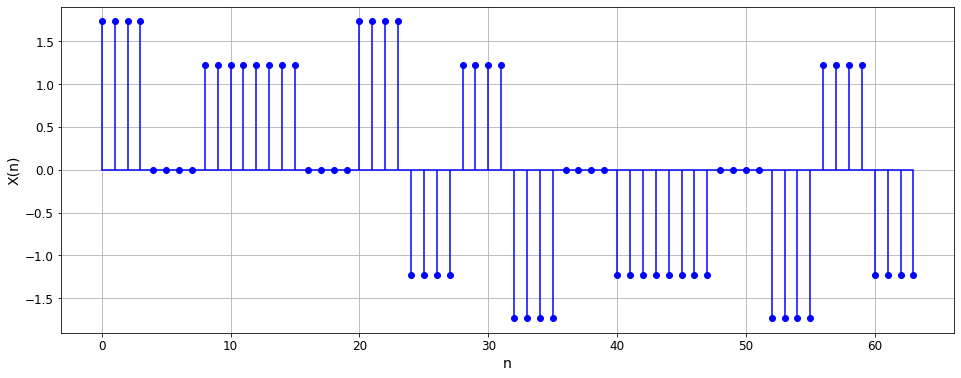

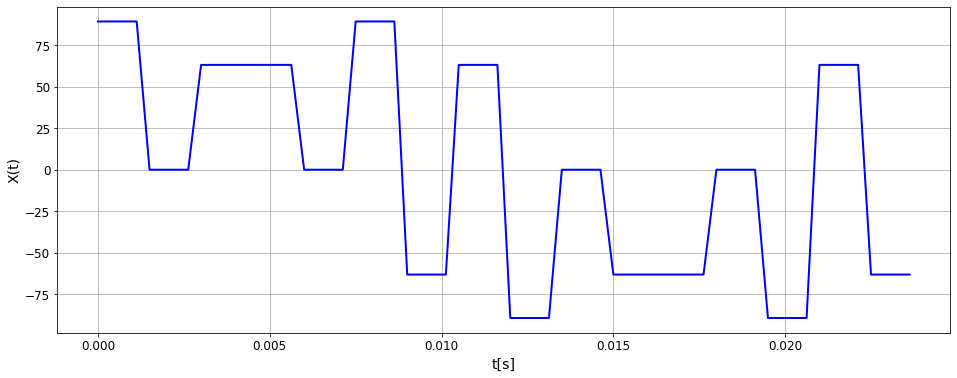

(None, None)

In [4]:
#Parámetros suministrados:
#Bn = Secuencia de dígitos binarios
Bn = np.array([0,0,0,0,0,1,0,1,1,0,1,0,1,1,0,1,1,1,1,0,1,1,0,0])
Eb = 4  # Eb = Energia media transmitida en Julios
M = 8  # M = número de símbolos
Rb = 10**3 # Rb = Tasa de bit de la señal
L = 8 # L = número de puntos que vamos a utilizar para transmitir un sí­mbolo

#Definición de los pulsos de las componentes en fase y cuadratura
p1 = np.r_[np.ones(int(L/2)), np.zeros(int(L/2))]
p2 = np.r_[np.zeros(int(L/2)), np.ones(int(L/2))]

#Generación de la señal modulada
[Xn, Bn, An, phi1, phi2, alfabeto] = transmisorpsk(Bn, Eb, M, p1, p2, L)

#Parámetros que han podido ser actualizados por transmisorpsk
L = len(phi1) #Número de muestras por símbolo
Nb = len(Bn) #Número de bits transmitidos
M = len(alfabeto) #Número de símbolos de la constelación

# Representación en tiempo discreto
plt.figure(51,figsize=(16, 6))
plt.stem(Xn,linefmt='b-',markerfmt='bo',basefmt='b-',use_line_collection = True)
plt.xlabel('n'); plt.ylabel('X(n)')
plt.grid(), plt.show()

#Definición de los parámetros del tiempo continuo para representar
Tb = 1/Rb            #Duración del bit en segundos
Tm = (Tb*np.log2(M))/L  #Intervalo entre cada muestra de la señal
Td = Tb*Nb         #Duración total de la señal
t = np.arange(0,Td,Tm)    #Eje de representación de la señal en tiempo continuo
Xt = np.sqrt(1/Tm)*Xn

# Representación en tiempo continuo
plt.figure(52,figsize=(16, 6)); plt.plot(t,Xt, linewidth=2.0, COLOR='b')
plt.xlabel('t[s]'), plt.ylabel('X(t)')
plt.grid(), plt.show()

**Código 5.3** Generación de una señal M-PSK paso de banda utilizando la función transmisorpsk

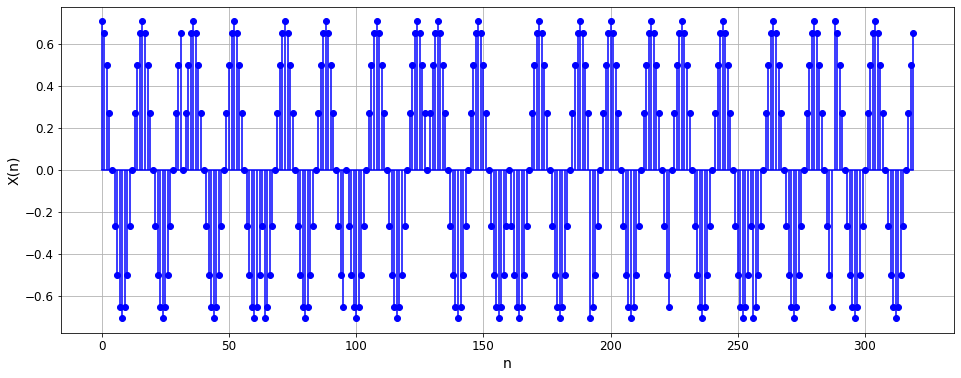

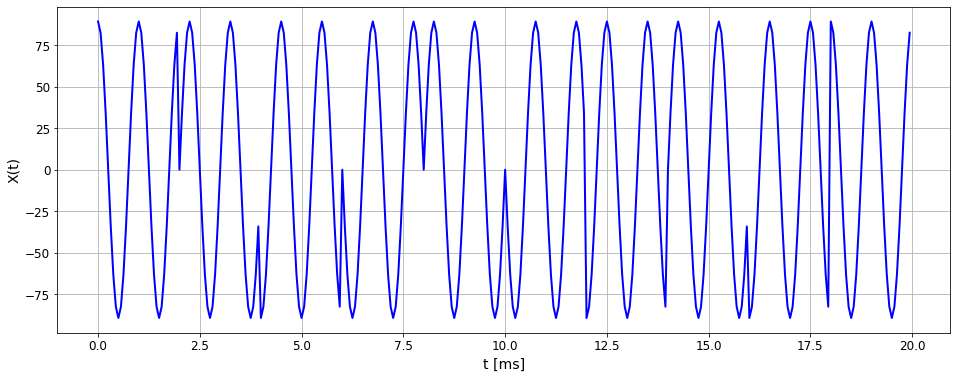

(None, None)

In [5]:
#Parámetros suministrados:
#Bn = Secuencia de dígitos binarios
Bn = np.array([0,0,0,1,1,1,1,0,0,1,1,0,1,1,0,1,1,1,0,0])
Eb = 4 #Eb = Energia media transmitida en Julios
M = 4 # M = número de símbolos
Rb = 10**3 # Rb = Tasa de bit de la señal
L = 32 #L = número de puntos que vamos a utilizar para transmitir un sí­mbolo

#Definición de los pulsos de las componentes en fase y cuadratura
p1 = np.cos(2*np.pi*np.arange(L)/(L/2))
p2 = np.sin(2*np.pi*np.arange(L)/(L/2))

# Se genera la señal modulada
[Xn, Bn, An, phi1, phi2, alfabeto] = transmisorpsk(Bn, Eb, M, p1, p2, L)

#Parámetros que han podido ser actualizados por transmisorpsk
L = len(phi1)    #Número de muestras por símbolo
Nb = len(Bn)    #Número de bits transmitidos
M = len(alfabeto)   #Número de símbolos de la constelación

# Representación en tiempo discreto
plt.figure(53,figsize=(16, 6))
plt.stem(Xn,linefmt='b-',markerfmt='bo',basefmt='b-',use_line_collection = True)
plt.xlabel('n'); plt.ylabel('X(n)')
plt.grid(), plt.show()

#Definición de los parámetros del tiempo continuo para representar
Tb = 1/Rb                #Duración del bit en segundos
Tm = (Tb*np.log2(M))/L      #Intervalo entre cada muestra de la señal
Td = Tb*Nb             #Duración total de la señal
t = np.arange(0,Td,Tm)*1e3    #Eje de representación de la señal en tiempo continuo
Xt = np.sqrt(1/Tm)*Xn

# Representación en tiempo continuo
plt.figure(54,figsize=(16, 6)), plt.plot(t,Xt, linewidth=2.0,color='b')
plt.xlabel('t [ms]'), plt.ylabel('X(t)')
plt.grid(), plt.show()

## Transmisor QAM rectangular: diseño experimental

**Código 5.4** Obtención de las secuencias en fase y cuadratura

In [6]:
def split(Bn, M1, M2):
    '''
    Entradas
        Bn = una secuencia de símbolos binarios
        M1 = nº de símbolos de la componente en fase
        M2 = nº de símbolos de la componente en cuadratura    
    Salida     
        Bn = una secuencia de símbolos binarios
        M1 = nº de símbolos de la componente en fase
        M2 = nº de símbolos de la componente en cuadratura
    '''
    
    k1 = int(np.log2(M1))
    k2 = int(np.log2(M2))
    k = k1 + k2
    
    #Longitud de la secuencia
    Nb = len(Bn)
    
    #Una matriz con Ns=Nb/k filas formadas por los k bits
    W = np.reshape(Bn,[int(Nb/k),k])
    
    #Extrae la submatriz formada por los k1 primeros bits y pone una fila tras otra
    BnI = np.reshape(W[:,:k1],[k1*int(Nb/k)])
    
    #Extrae la submatriz formada por los k2 bits restantes y pone una fila tras otra
    BnQ = np.reshape(W[:,k1:],[k2*int(Nb/k)]) 
    
    return BnI, BnQ

### Ejemplos de uso de la función transmisorpam

**Código 5.5** Transmisor QAM rectangular

In [7]:
def transmisorqam(Bn, Eb, M1, M2, p1, p2, L): 
    '''
    [Xn,BnI,BnQ,AnI,AnQ,AI,AQ,phi1,phi2] = transmisorqam(Bn, Eb, M1, M2,p1,p2,L)
    
    Entradas:
     Bn = Secuencia de dígitos binarios
     Eb = Energía media por bit transmitida en Julios
     M1 = Nº de símbolos de la componente en fase
     M2 = Nº de símbolos de la componente en cuadratura
     p1 = Pulso real de la componente en fase
     p2 = Pulso real de la componente en cuadratura
     L = Nº de puntos que vamos a utilizar en la representación un símbolo
        
    Devuelve:
     Xn = la señal de información digital
     BnI = Bits transmitidos por la componente en fase
     BnQ = Bits transmitidos por la componente en cuadratura
     AnI = Niveles de amplitud transmitidos por la componente en fase
     AnQ = Niveles de amplitud transmitidos por la componente en cuadratura 
     AI = Niveles de amplitud usados en la componente en fase
     AQ = Niveles de amplitud usados en la componente en cuadratura
     phi1 = Pulso básico normalizado (energí­a unidad) de la componente en fase
     phi2 = Pulso básico normalizado (energí­a unidad) de la componente en cuadratura 
    '''
    #Comprobación de parámetros de entrada
    if len(Bn)<1 or Eb<=0 or M1<2 or M2<2  or p1@p1==0 or p2@p2==0 or L<1:
       raise Exception('Error: revise los parámetros de entrada')    
       
    #Definiciones
    eps = np.finfo(float).eps # por debajo de este valor se considera cero
    
    #Comprobación de los pulsos básicos
    Ls1 = len(p1)
    Ls2 = len(p2)
    if Ls1<L:
        p1 = np.r_[p1, np.zeros(int(L-Ls1))]
    elif Ls1>L:
        p1 = p1[:L]
        print('La duración del pulso se trunca a {} muestras'.format(str(L)))
    if Ls2<L:
        p2 = np.r_[p2, np.zeros(int(L-Ls2))]
    elif Ls1>L:
        p2 = p2[:L]
        print('La duración del pulso se trunca a {} muestras'.format(str(L)))       

    #Normalicemos las energías de los pulsos
    phi1 = 1/np.sqrt(p1@p1)*p1
    phi2 = 1/np.sqrt(p2@p2)*p2
    
    #Comprobemos la ortogonalidad
    if np.abs(phi1@phi2) >= 1e2*eps:
        raise Exception('Bases no ortogonales, no es posible realizar la transmisión')
    
    #Ajuste de los parámetros   
    k1 = int(np.ceil(np.log2(M1))) #Número de bits de la componente en fase
    M1 = 2**(k1) #Valor de M1 tras la corrección
    k2 = int(np.ceil(np.log2(M2))) #Número de bist de la componente en cuadratura M2 = 2**(k2) #Valor de M2 tras la corrección
    k = k1 + k2 #Número de bits en cada símbolo QAM
    Nb = len(Bn); Bn = Bn.squeeze().astype(int) #Comprobación de int y dimensiones
    Bn = np.r_[Bn,np.zeros(int(k*np.ceil(Nb/k)-Nb)).astype(int)]    
    
    #Obtención de la mitad de la distancia mínima entre símbolos para Eb dada
    A = np.sqrt(3*Eb*np.log2(M1*M2)/(M1**2+M2**2-2))
    
    #El alfabeto con los niveles
    AI = A * (2*np.arange(M1)-M1+1)
    AQ = A * (2*np.arange(M2)-M2+1)
    
    #Separación de la secuencia de bits en las secuencias de las componentes en fase y cuadratura
    BnI,BnQ = split(Bn,M1,M2)
    NbI = len(BnI)
    NbQ = len(BnQ)
    
    #Obtención de la secuencia de símbolos de las componentes en fase y cuadratura
    if M1>2:
        AnI = AI[gray2de(np.reshape(BnI,[int(NbI/k1),k1]))] 
    else:
        AnI = AI[BnI]
    if M2>2:
        AnQ = AQ[gray2de(np.reshape(BnQ,[int(NbQ/k2),k2]))]
    else:
        AnQ = AQ[BnQ]
    Ns = len(AnI)    
    
    #Las componentes en fase, cuadratura y total de la señal discreta a transmitir
    XnI=np.reshape(np.reshape(AnI,[Ns,1])*phi1,[Ns*L,]) #ó XnI=np.kron(AnI, phi1);
    XnQ=np.reshape(np.reshape(AnQ,[Ns,1])*phi2,[Ns*L,]) #ó XnQ=np.kron(AnQ, phi2);
    Xn = XnI+XnQ;
    return Xn, BnI, BnQ, AnI, AnQ, AI, AQ, phi1, phi2 

**Código 5.6** Generación de una señal QAM rectangular paso de baja

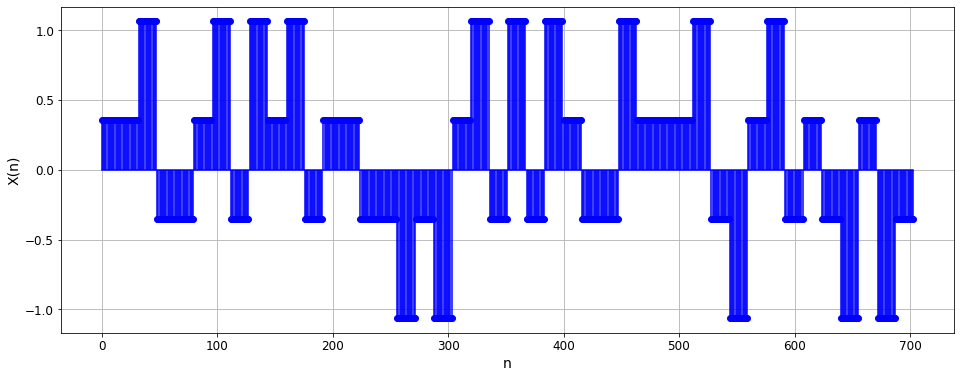

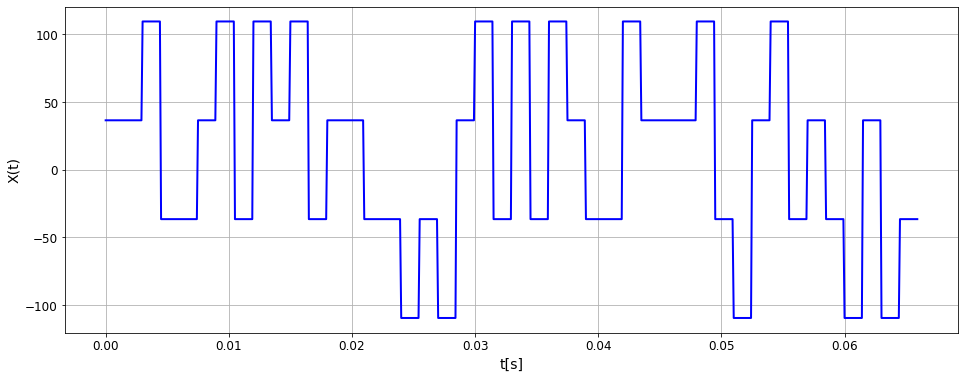

(None, None)

In [8]:
#Parámetros suministrados:
#Bn = Secuencia de dígitos binarios
Bn = np.random.randint(2,size=[64])
Eb = 4 # Eb = Energia media transmitida en Julios
M1 = 4 # M1 = Nº de símbolos de la componente en fase
M2 = 2 # M2 = Nº de símbolos de la componente en cuadratura
Rb = 10**3 # Rb = Tasa de bit de la señal
L = 32 # L = número de puntos que vamos a utilizar para transmitir un sí­mbolo

#Definición de los pulsos de las componentes en fase y cuadratura
p1 = np.r_[np.ones(int(L/2)), np.zeros(int(L/2))] 
p2 = np.r_[np.zeros(int(L/2)), np.ones(int(L/2))]

# Señal modulada QAM
[Xn,BnI,BnQ,AnI,AnQ,AI,AQ,phi1,phi2] = transmisorqam(Bn, Eb, M1, M2,p1, p2, L);

#Parámetros que han podido ser actualizados por transmisorpsk
L = len(phi1)          #Número de muestras por símbolo
Nb = len(BnI)+len(BnQ) #Número de bits transmitidos
M = len(AI)*len(AQ)	   #Número de símbolos de la constelación

# Representación en tiempo discreto
plt.figure(55,figsize=(16, 6))
plt.stem(Xn,linefmt='b-',markerfmt='bo',basefmt='b-', use_line_collection = True)
plt.xlabel('n'); plt.ylabel('X(n)')
plt.grid(), plt.show()

#Definición de los parámetros del tiempo continuo para representar
Tb = 1/Rb                #Duración del bit en segundos
Tm = (Tb*np.log2(M))/L      #Intervalo entre cada muestra de la señal
Td = Tb*Nb             #Duración de la señal
t = np.arange(0,Td,Tm)         #Eje de representación de la señal en tiempo continuo
Xt = np.sqrt(1/Tm) * Xn

# Representación en tiempo continuo
plt.figure(56,figsize=(16, 6)), plt.plot(t,Xt, linewidth=2.0,color='b')
plt.xlabel('t[s]'), plt.ylabel('X(t)')
plt.grid(), plt.show()
